# Chapter 8

In [96]:
# load modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
from IPython.display import Image, display

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor,export_graphviz, DecisionTreeClassifier
from sklearn.metrics import accuracy_score

sns.set_style('whitegrid')
%matplotlib inline

## Question 7

In [2]:
# import data
boston = pd.read_csv('./datasets/Boston.csv')
boston.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
crim       506 non-null float64
zn         506 non-null float64
indus      506 non-null float64
chas       506 non-null int64
nox        506 non-null float64
rm         506 non-null float64
age        506 non-null float64
dis        506 non-null float64
rad        506 non-null int64
tax        506 non-null int64
ptratio    506 non-null float64
black      506 non-null float64
lstat      506 non-null float64
medv       506 non-null float64
dtypes: float64(11), int64(3)
memory usage: 55.4 KB


In [3]:
# Extract predictors and target
X = boston.drop('medv',axis=1)
y = boston['medv']

In [4]:
# The lab uses a 50/50 split. We'll do the same
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

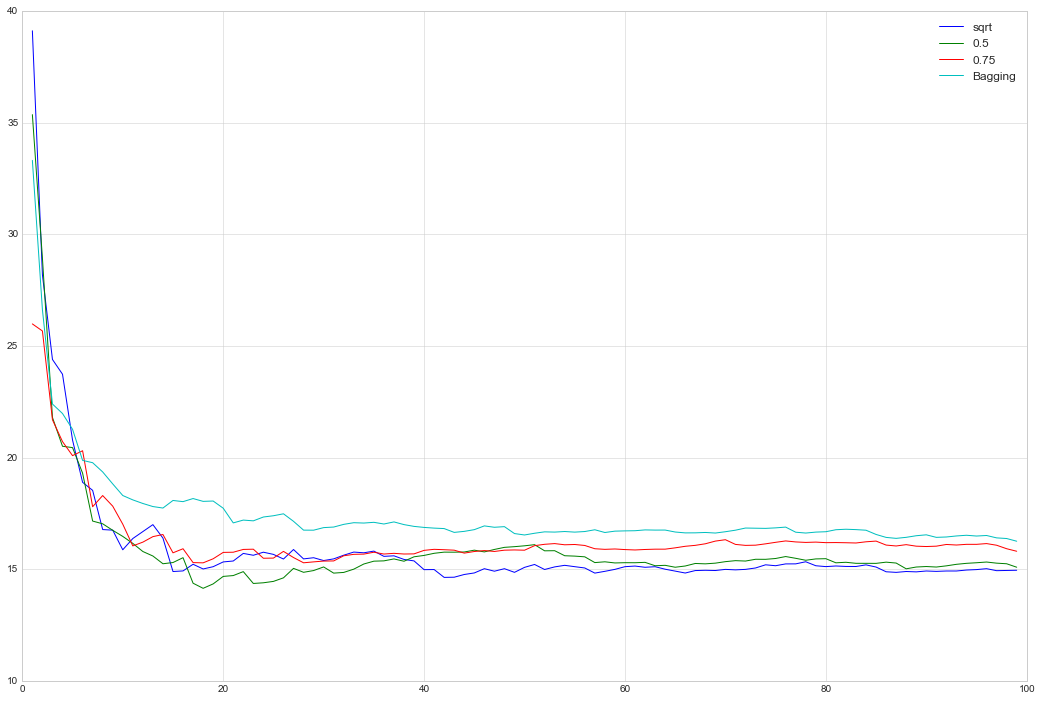

In [5]:
# study the impact of the number of trees on the Bagging model and a few Random Forest models
num_features = ['sqrt',0.5,0.75,None]
trees = range(1,100)

# store the errors
erros = np.zeros((len(trees),len(num_features)))

fig, ax = plt.subplots(figsize=(18,12))
for idx, feature in enumerate(num_features):
    temp_error = []
    for k_tree in trees:
        random_forest = RandomForestRegressor(n_estimators=k_tree,criterion='mse',max_features=feature,
                                             bootstrap=True,random_state=1).fit(X_train,y_train)
        temp_error.append(np.mean((random_forest.predict(X_test)-y_test)**2))
    erros[:,idx] = temp_error
    
    if feature is None:
        label = 'Bagging'
    else:
        label = str(feature)
    ax.plot(trees, temp_error,label=label)
    
ax.legend(loc='best')

## Question 8

In [6]:
# import data
carseats = pd.read_csv('./datasets/Carseats.csv', index_col=0)
# create dummy variables for the categoricals
carseats = pd.get_dummies(carseats, columns=['ShelveLoc', 'Urban', 'US'])
carseats.head()

Sales  CompPrice  Income  Advertising  Population  Price  Age  Education  \
1   9.50        138      73           11         276    120   42         17   
2  11.22        111      48           16         260     83   65         10   
3  10.06        113      35           10         269     80   59         12   
4   7.40        117     100            4         466     97   55         14   
5   4.15        141      64            3         340    128   38         13   

   ShelveLoc_Bad  ShelveLoc_Good  ShelveLoc_Medium  Urban_No  Urban_Yes  \
1              1               0                 0         0          1   
2              0               1                 0         0          1   
3              0               0                 1         0          1   
4              0               0                 1         0          1   
5              1               0                 0         0          1   

   US_No  US_Yes  
1      0       1  
2      0       1  
3      0       1  
4      0       1  
5      1       0

In [7]:
# set predictors and target
X = carseats[carseats.columns.difference(['Sales'])]
y = carseats['Sales']

In [8]:
# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)

In [9]:
clf = DecisionTreeRegressor(min_samples_split=15,random_state=1,max_features=None)

tree_est = clf.fit(X,y)

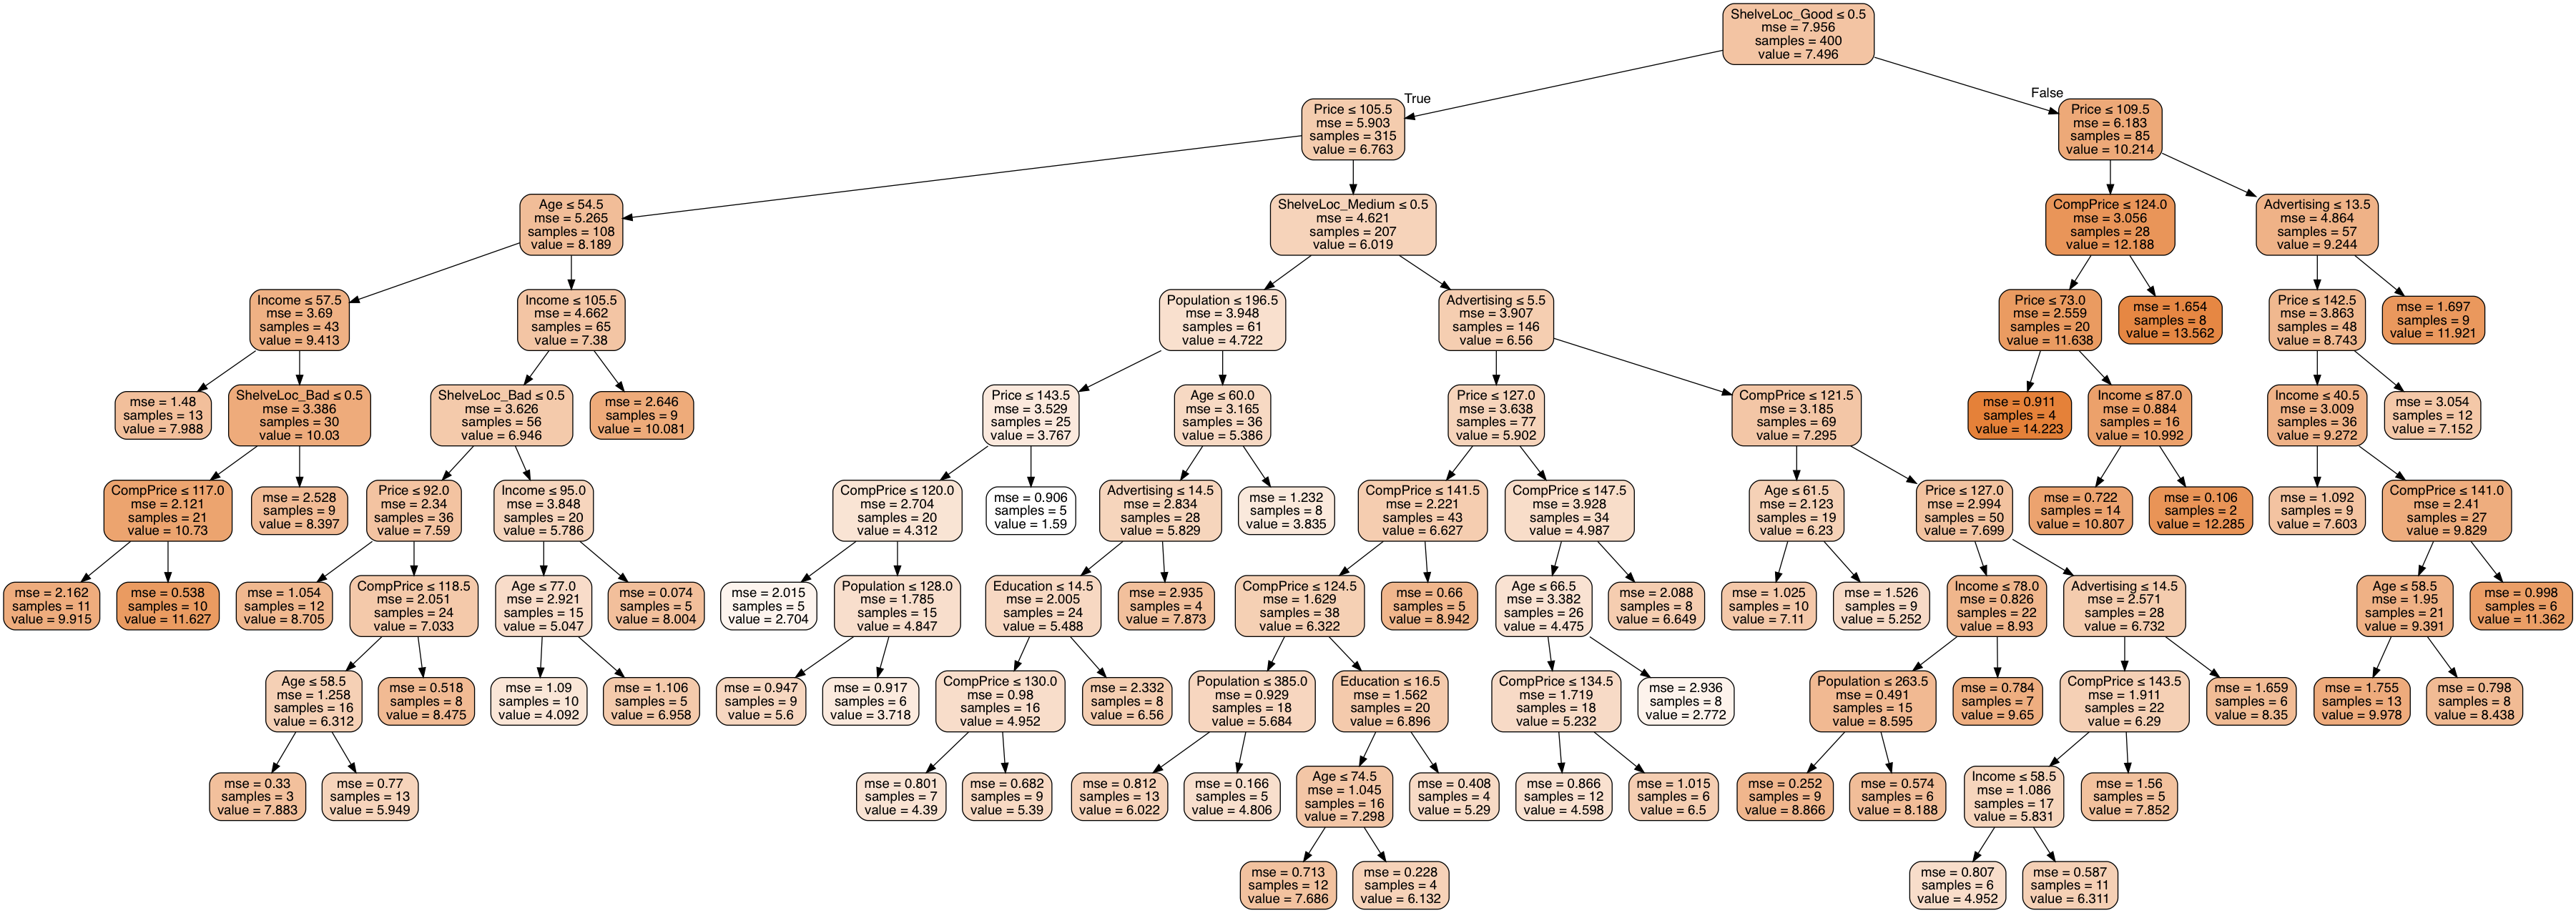

In [10]:
# plot the tree
dot_data = export_graphviz(tree_est, out_file='seat_tree2.dot',feature_names=X.columns,
                          class_names=['True','False'],filled=True,rounded=True,
                          special_characters=True)

with open('seat_tree2.dot') as f:
    dot_graph = f.read()
    
I = graphviz.Source(dot_graph,format='png', engine='dot')
Image(I.render())

Test MSE =  1.0424804853688496


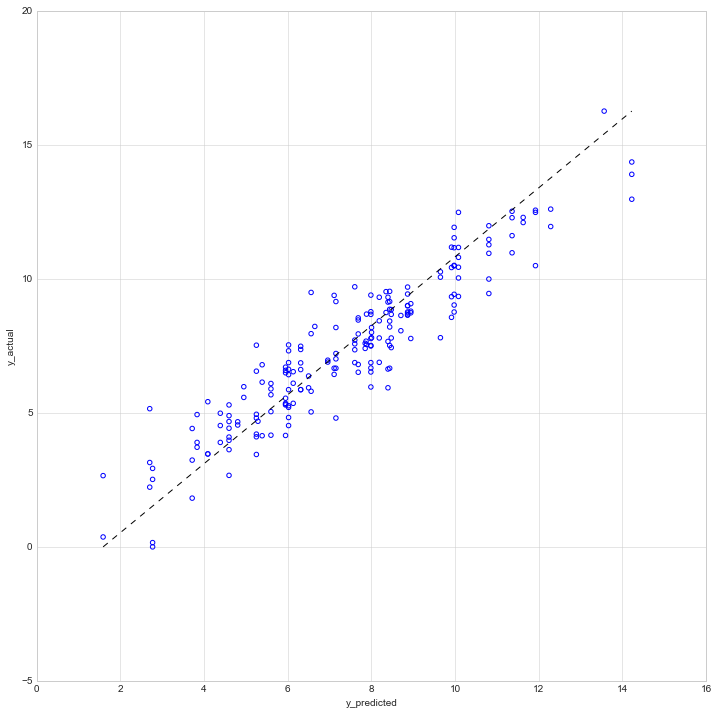

In [11]:
# compute test MSE
y_pred = tree_est.predict(X_test)

# plot
fig,ax = plt.subplots(figsize=(12,12));
ax.scatter(y_pred, y_test, facecolor='None', edgecolor='b');
# add a reference unity line
ax.plot([min(y_pred), max(y_pred)], [min(y_test), max(y_test)], linestyle='--', color='k');
ax.set_xlabel('y_predicted')
ax.set_ylabel('y_actual')

# print the mse
print("Test MSE = ", np.mean((y_pred-y_test)**2))

In [12]:
# inspect feature importances
feature_importances = tree_est.feature_importances_
pd.DataFrame(data=feature_importances,index=X_train.columns,columns=['Importance']).sort_values(by=['Importance'],ascending=False)

Importance
ShelveLoc_Good      0.296217
Price               0.272550
Age                 0.088056
CompPrice           0.086905
Income              0.073039
Advertising         0.069332
ShelveLoc_Medium    0.054004
ShelveLoc_Bad       0.028289
Population          0.021696
Education           0.009913
US_No               0.000000
US_Yes              0.000000
Urban_No            0.000000
Urban_Yes           0.000000

In [13]:
# bagging
bagger = RandomForestRegressor(n_estimators=500, max_features='auto', random_state=0)
bag_est = bagger.fit(X_train, y_train.values.reshape(-1,))

bagging_mse = np.mean((bag_est.predict(X_test)-y_test)**2)
print('Bagging MSE = ', bagging_mse)

Bagging MSE =  2.8484886682220063


In [14]:
# inspect feature importances
feature_importances = bag_est.feature_importances_
pd.DataFrame(data=feature_importances,index=X_train.columns,columns=['Importance']).sort_values(by=['Importance'],ascending=False)

Importance
Price               0.296615
ShelveLoc_Good      0.193076
Age                 0.102663
ShelveLoc_Bad       0.102632
CompPrice           0.080406
Advertising         0.057374
Income              0.049461
Population          0.044062
ShelveLoc_Medium    0.033714
Education           0.026118
Urban_No            0.004971
Urban_Yes           0.004006
US_No               0.002735
US_Yes              0.002167

In [15]:
# Random Forest sqrt(p) features
forest = RandomForestRegressor(n_estimators=500, max_features='sqrt', random_state=0)
forest_est = forest.fit(X_train, y_train.values.reshape(-1,))

forest_mse = np.mean((forest_est.predict(X_test)-y_test)**2)
print('Random Forest MSE = ', forest_mse)

Random Forest MSE =  3.071673347905992


In [16]:
# Random Forest (p/2) features
forest2 = RandomForestRegressor(n_estimators=500, max_features=0.5, random_state=0)
forest_est2 = forest2.fit(X_train, y_train.values.reshape(-1,))

forest_mse2 = np.mean((forest_est2.predict(X_test)-y_test)**2)
print('Random Forests MSE = ', forest_mse2)

Random Forests MSE =  2.7925773834180023


In [17]:
# inspect feature importances
feature_importances = forest_est2.feature_importances_
pd.DataFrame(data=feature_importances,index=X_train.columns,columns=['Importance']).sort_values(by=['Importance'],ascending=False)

Importance
Price               0.261058
ShelveLoc_Good      0.161677
ShelveLoc_Bad       0.110927
Age                 0.095708
CompPrice           0.081652
Income              0.065864
Advertising         0.064738
Population          0.051507
ShelveLoc_Medium    0.048883
Education           0.034218
US_No               0.006245
Urban_No            0.006093
US_Yes              0.005799
Urban_Yes           0.005631

## Question 9

In [28]:
# import data
OJ = pd.read_csv('./datasets/OJ.csv')
OJ = pd.get_dummies(OJ, columns=['Store7'])
OJ.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1070 entries, 0 to 1069
Data columns (total 20 columns):
Unnamed: 0        1070 non-null int64
Purchase          1070 non-null object
WeekofPurchase    1070 non-null int64
StoreID           1070 non-null int64
PriceCH           1070 non-null float64
PriceMM           1070 non-null float64
DiscCH            1070 non-null float64
DiscMM            1070 non-null float64
SpecialCH         1070 non-null int64
SpecialMM         1070 non-null int64
LoyalCH           1070 non-null float64
SalePriceMM       1070 non-null float64
SalePriceCH       1070 non-null float64
PriceDiff         1070 non-null float64
PctDiscMM         1070 non-null float64
PctDiscCH         1070 non-null float64
ListPriceDiff     1070 non-null float64
STORE             1070 non-null int64
Store7_No         1070 non-null uint8
Store7_Yes        1070 non-null uint8
dtypes: float64(11), int64(6), object(1), uint8(2)
memory usage: 152.6+ KB


In [29]:
OJ.head()

Unnamed: 0 Purchase  WeekofPurchase  StoreID  PriceCH  PriceMM  DiscCH  \
0           1       CH             237        1     1.75     1.99    0.00   
1           2       CH             239        1     1.75     1.99    0.00   
2           3       CH             245        1     1.86     2.09    0.17   
3           4       MM             227        1     1.69     1.69    0.00   
4           5       CH             228        7     1.69     1.69    0.00   

   DiscMM  SpecialCH  SpecialMM   LoyalCH  SalePriceMM  SalePriceCH  \
0     0.0          0          0  0.500000         1.99         1.75   
1     0.3          0          1  0.600000         1.69         1.75   
2     0.0          0          0  0.680000         2.09         1.69   
3     0.0          0          0  0.400000         1.69         1.69   
4     0.0          0          0  0.956535         1.69         1.69   

   PriceDiff  PctDiscMM  PctDiscCH  ListPriceDiff  STORE  Store7_No  \
0       0.24   0.000000   0.000000           0.24      1          1   
1      -0.06   0.150754   0.000000           0.24      1          1   
2       0.40   0.000000   0.091398           0.23      1          1   
3       0.00   0.000000   0.000000           0.00      1          1   
4       0.00   0.000000   0.000000           0.00      0          0   

   Store7_Yes  
0           0  
1           0  
2           0  
3           0  
4           1

In [35]:
# a)
# split data
X = OJ.drop(columns=['Purchase'],axis=1)
y = OJ['Purchase']
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=800)

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [36]:
# b)
# fit a tree to the data
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

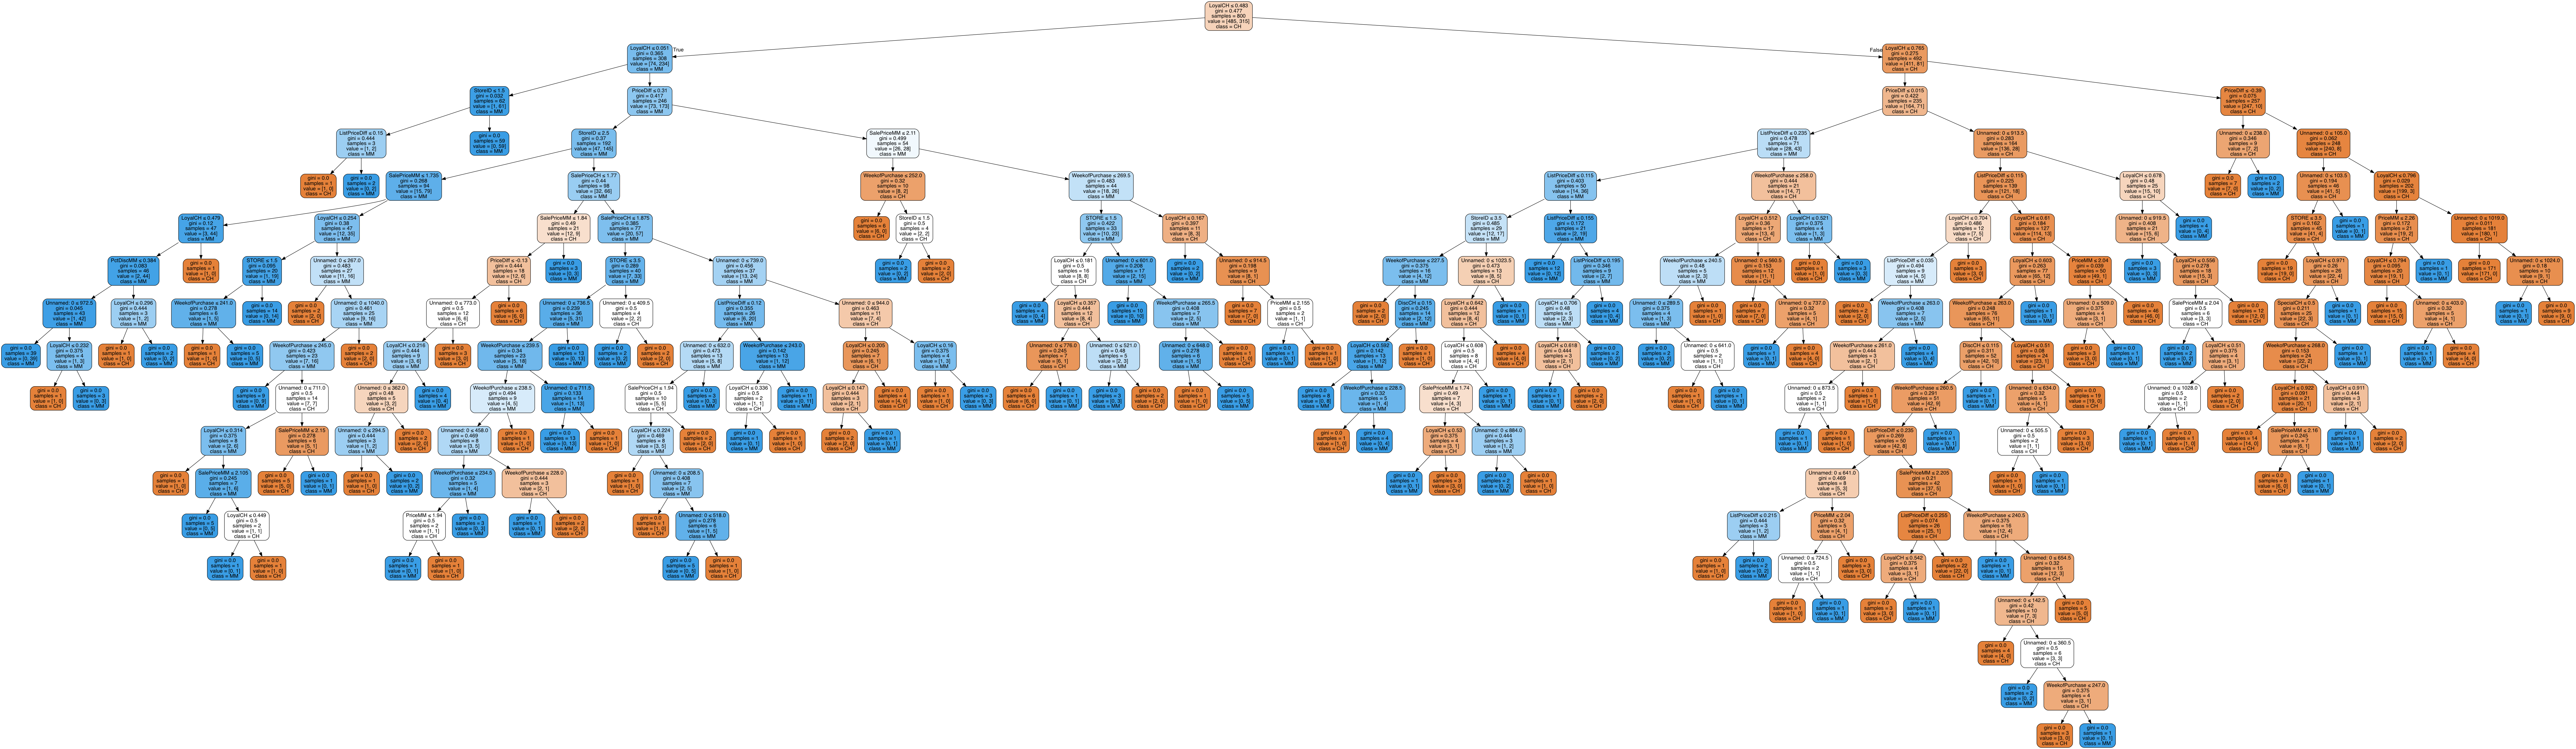

In [40]:
# plot the tree
dot_data = export_graphviz(tree, out_file='OJ_tree.dot',feature_names=X.columns,
                          class_names=['CH','MM'],filled=True,rounded=True,
                          special_characters=True)

with open('OJ_tree.dot') as f:
    dot_graph = f.read()
    
I = graphviz.Source(dot_graph,format='png', engine='dot')
Image(I.render())

In [52]:
# compute the training error rate
train_error = 1-np.mean(tree.predict(X_train).reshape(-1,1)==y_train.values.reshape(-1,1))
print('Training Error Rate = ', train_error)

# how many terminal nodes
print("Number of Leaves = ", tree.tree_.node_count)

Training Error Rate =  0.0
Number of Leaves =  299


In [53]:
# compute the training error rate
test_error = 1-np.mean(tree.predict(X_test).reshape(-1,1)==y_test.values.reshape(-1,1))
print('Training Error Rate = ', test_error)

Training Error Rate =  0.24444444444444446


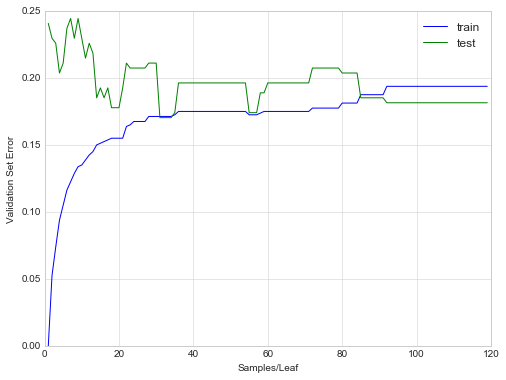

In [72]:
errors_train=[]
errors_test=[]
for sample in range(1,120):
        # make a tree, fit it and store error
        tree_est = DecisionTreeClassifier(min_samples_leaf=sample).fit(X_train,y_train)
        errors_test.append(1-np.mean(tree_est.predict(X_test).reshape(-1,1)==y_test.values.reshape(-1,1)))
        errors_train.append(1-np.mean(tree_est.predict(X_train).reshape(-1,1)==y_train.values.reshape(-1,1)))
        
# plt the errors as a function of the number of samples/leaf 
fig, ax =plt.subplots(1,1,figsize=(8,6))
ax.plot(range(1,120), errors_train,label='train')
ax.plot(range(1,120), errors_test,label='test')
ax.legend(loc='best')
ax.set_xlabel('Samples/Leaf');
ax.set_ylabel('Validation Set Error');

In [74]:
errors_test.index(min(errors_test))

30

In [76]:
pruned_tree = DecisionTreeClassifier(min_samples_leaf=30).fit(X_train,y_train)
pruned_tree.tree_.max_depth

6

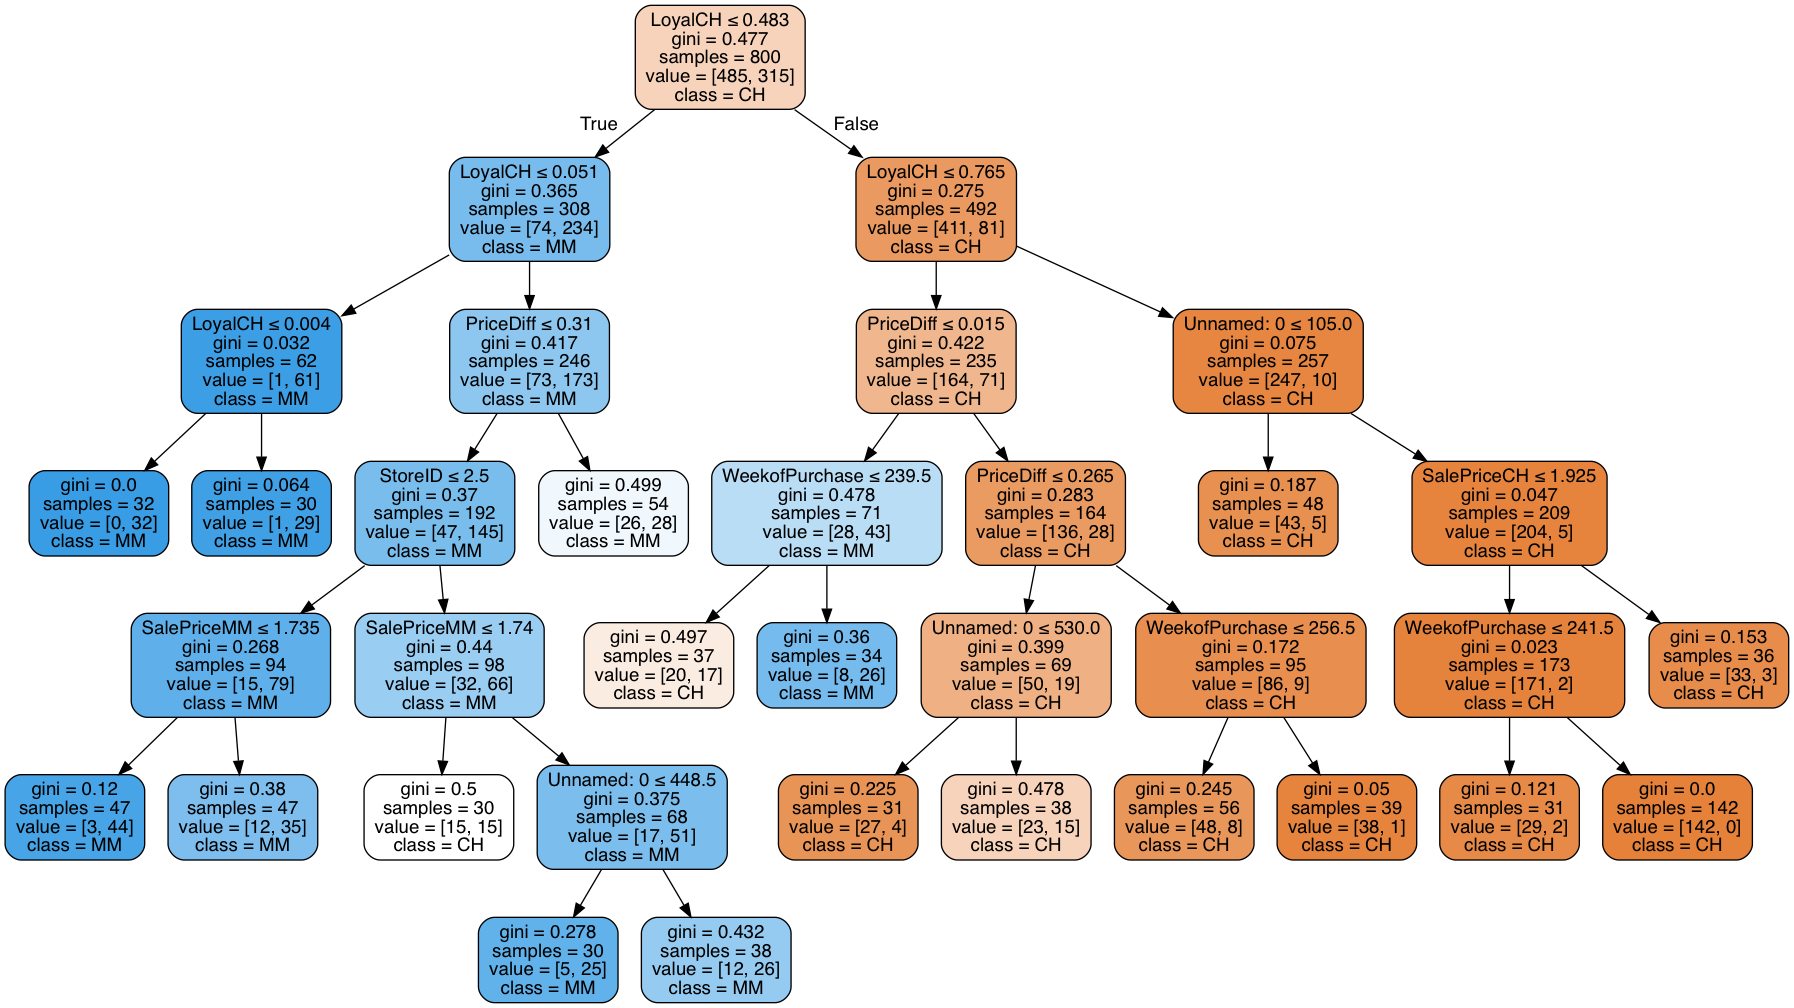

In [77]:
# plot the tree
dot_data = export_graphviz(pruned_tree, out_file='OJ_pruned_tree.dot',feature_names=X.columns,
                          class_names=['CH','MM'],filled=True,rounded=True,
                          special_characters=True)

with open('OJ_pruned_tree.dot') as f:
    dot_graph = f.read()
    
I = graphviz.Source(dot_graph,format='png', engine='dot')
Image(I.render())

In [82]:
unpruned_training_err = 1-np.mean(tree.predict(X_train).reshape(-1,1)==y_train.values.reshape(-1,1))
pruned_training_err = 1-np.mean(pruned_tree.predict(X_train).reshape(-1,1)==y_train.values.reshape(-1,1))
print('Unpruned Training Error = ', unpruned_training_err)
print('Pruned Training Error = ', pruned_training_err)

unpruned_test_err = 1-np.mean(tree.predict(X_test).reshape(-1,1)==y_test.values.reshape(-1,1))
pruned_test_err = 1-np.mean(pruned_tree.predict(X_test).reshape(-1,1)==y_test.values.reshape(-1,1))
print('Unpruned Test Error = ', unpruned_test_err)
print('Pruned Test Error = ', pruned_test_err)

Unpruned Training Error =  0.0
Pruned Training Error =  0.17125
Unpruned Test Error =  0.24444444444444446
Pruned Test Error =  0.21111111111111114


## Question 10

In [106]:
# load data
hitters = pd.read_csv('./datasets/Hitters.csv')
hitters.dropna(inplace=True)
hitters.drop(['Unnamed: 0'],axis=1,inplace=True)
hitters.head()

AtBat  Hits  HmRun  Runs  RBI  Walks  Years  CAtBat  CHits  CHmRun  CRuns  \
1    315    81      7    24   38     39     14    3449    835      69    321   
2    479   130     18    66   72     76      3    1624    457      63    224   
3    496   141     20    65   78     37     11    5628   1575     225    828   
4    321    87     10    39   42     30      2     396    101      12     48   
5    594   169      4    74   51     35     11    4408   1133      19    501   

   CRBI  CWalks League Division  PutOuts  Assists  Errors  Salary NewLeague  
1   414     375      N        W      632       43      10   475.0         N  
2   266     263      A        W      880       82      14   480.0         A  
3   838     354      N        E      200       11       3   500.0         N  
4    46      33      N        E      805       40       4    91.5         N  
5   336     194      A        W      282      421      25   750.0         A

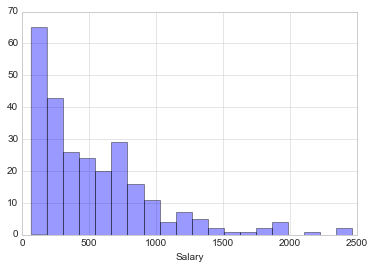

In [107]:
# plot salary distribution
sns.distplot(hitters['Salary'], bins=20,kde=False)

In [108]:
hitters['Salary'] = np.log(hitters['Salary'])

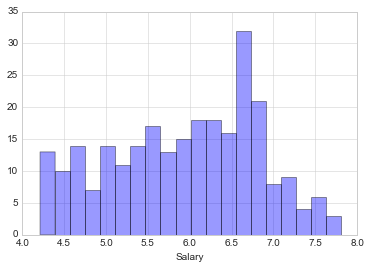

In [109]:
# plot salary distribution
sns.distplot(hitters['Salary'], bins=20,kde=False)

In [110]:
# create dummy variables for the qualitative predictors 
hitters = pd.get_dummies(data=hitters, columns=['League', 'Division', 'NewLeague'])

In [111]:
# Extract predictors and target
X = hitters.drop('Salary',axis=1)
y = hitters['Salary']

In [112]:
# The lab uses a 50/50 split. We'll do the same
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=200, random_state=0)

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [117]:
# Boosting with 1000 trees, tune lambda. Produce plots of MSE as function of lambda
params = 10**np.linspace(-5,-1,20)
train_mse = []
test_mse = []

for param in params:
    gdr = GradientBoostingRegressor(learning_rate=param,n_estimators=1000).fit(X_train,y_train)
    
    # get the gdr training error rate
    train_mse.append(np.mean((y_train-gdr.predict(X_train))**2))
    
    # get the gdr test error rate
    test_mse.append(np.mean((y_test-gdr.predict(X_test))**2))

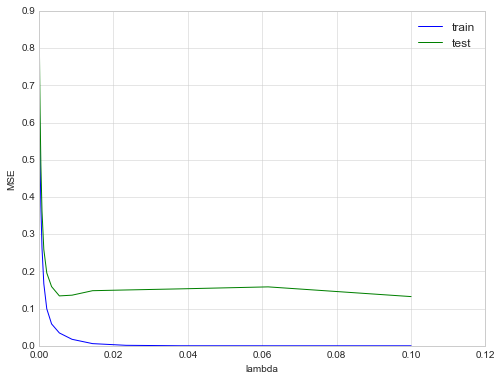

In [120]:
fig, ax =plt.subplots(1,1,figsize=(8,6))
ax.plot(params, train_mse,label='train')
ax.plot(params, test_mse,label='test')
ax.legend(loc='best')
ax.set_xlabel('lambda');
ax.set_ylabel('MSE');

In [122]:
params[test_mse.index(min(test_mse))]

0.1

In [124]:
# optimal model
gdr = GradientBoostingRegressor(learning_rate=0.1,n_estimators=1000).fit(X_train,y_train)

In [125]:
# inspect feature importances
feature_importances = gdr.feature_importances_
pd.DataFrame(data=feature_importances,index=X_train.columns,columns=['Importance']).sort_values(by=['Importance'],ascending=False)

Importance
PutOuts        0.086191
CWalks         0.086045
Runs           0.069678
Hits           0.059753
CHmRun         0.058881
Assists        0.058390
Walks          0.053565
AtBat          0.051437
CAtBat         0.051364
CRBI           0.051133
CRuns          0.049929
RBI            0.049560
CHits          0.037561
Years          0.032773
HmRun          0.030839
Errors         0.028603
Division_W     0.003197
NewLeague_N    0.001857
League_A       0.001814
NewLeague_A    0.001615
Division_E     0.001592
League_N       0.001222